# 作业七

Sersic profile: $I(r)=I_0exp(-(\frac{r}{R_d})^{1/n})$  
r_100为f(x)积分0到∞，$f(x)=2\pi I_0R_d^2$  
任意半径r内包含的流量：$f(x)=2\pi I_0(-R_d*exp(-\frac{r}{R_d})(r+R_d)+R_d^2)$


In [1]:
from scipy.integrate import quad
import numpy as np
import math

In [31]:
# x = r/Rd
# I0 = 10
def I_1(x):  
    return 10*np.exp(-(x)**1/1)
I100_1,err100_1 = quad(I_1,0,np.inf)
r90_1, err90_1 = quad(I_1,0,)
print(r100_1)


10.0


# 作业八

选用HST F555W NGC4478

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

### 1. 看看图

Text(0.5, 1.0, 'Zoom-in NGC4478 SDSS g-band')

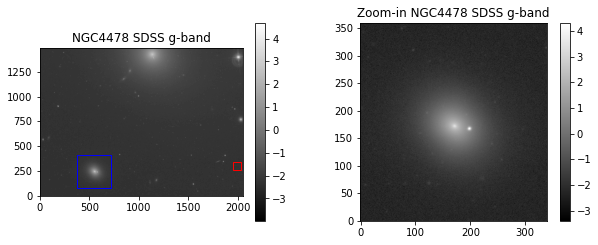

In [21]:
file = fits.open('./frame-g-003836-3-0258.fits')
data = file[0].data

plt.figure(figsize=(10,8))
ax = plt.subplot(221)
plt.imshow(np.log(data+0.1),origin='lower',cmap='gray')
plt.colorbar()
plt.title('NGC4478 SDSS g-band')
rect1 = plt.Rectangle((1950,260),80,80,fill=False,edgecolor='red',linewidth=1)
ax.add_patch(rect1)
rect2 = plt.Rectangle((380,74),340,340,fill=False,edgecolor='blue',linewidth=1)
ax.add_patch(rect2)

img = data[74:434,380:720]
plt.subplot(222)
plt.imshow(np.log(img+0.1),origin='lower',cmap='gray')
plt.colorbar()
plt.title('Zoom-in NGC4478 SDSS g-band')


### 2. 计算background

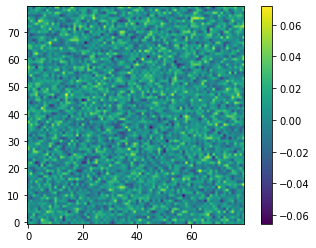

In [22]:
area = data[260:340,1950:2030]
plt.imshow(area,origin='lower')
plt.colorbar()

background= 0.0040074554
-0.07454324


/tmp/ipykernel_30081/1659043533.py:11: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img),origin='lower')
/tmp/ipykernel_30081/1659043533.py:11: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(img),origin='lower')


Text(0.5, 1.0, 'Subtract background value')

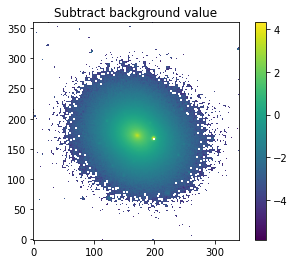

In [27]:
# 找一块看起来干净的区域计算背景值，即图红色框内
# 红框内计算背景值
bg = np.mean(area)  
print('background=',bg)

img = img - bg
print(img.min())
#img[np.where(img<0)]=0
# 将img减去背景值
plt.subplot(111)
plt.imshow(np.log(img),origin='lower')
#plt.clim(0,10)
plt.colorbar()
plt.title('Subtract background value')

### 3. mask 恒星

In [31]:
# 用DAOStarFinder找恒星
from photutils import DAOStarFinder, CircularAperture, aperture_photometry

daofind = DAOStarFinder(fwhm=2, threshold=30, exclude_border=True)  #fwhm、threshold参数可调，选合适的
sources = daofind(img)
for col in sources.colnames:
    sources[col].info.format = '%.8g'
print('number of the sources finded:',len(sources))  # 找到源的个数
print(sources)  # 找到的源的信息

number of the sources finded: 1
 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
  1 198.28535 167.64685 0.56909849 ...   0 70.616989 2.1084588 -0.80991278


165
169


/tmp/ipykernel_30081/115342671.py:4: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(img), origin='lower')
/tmp/ipykernel_30081/115342671.py:17: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(img), origin='lower')


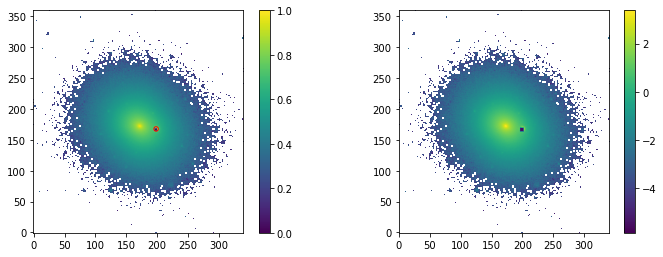

In [42]:
# 在图像上找到的源的位置
plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(np.log(img), origin='lower')
plt.scatter(sources['xcentroid'],sources['ycentroid'],s=20, marker='o',facecolor='none',edgecolor='red',linewidth=1)  #DAOStarFinder
plt.colorbar()

#del sources[12]  # 将第13个从恒星列表里删掉，因为他应该是星系

# 将DAOStarFinder找的恒星赋予background值
for i in range(len(sources)):
    img[int(sources['ycentroid'][i])-3:int(sources['ycentroid'][i])+3,
        int(sources['xcentroid'][i])-3:int(sources['xcentroid'][i])+3]=bg

plt.subplot(222)
plt.imshow(np.log(img), origin='lower')
plt.colorbar()

### 4. 取孔径

center of NGC478: [172] [172]


/tmp/ipykernel_30081/4098895071.py:22: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(img), origin='lower', cmap='gray')


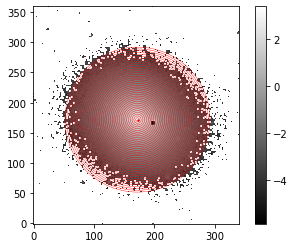

In [59]:
# 星系中心
center_x,center_y = np.where(img==np.max(img))
print('center of NGC478:',center_y,center_x)

# 画圆环，计算每一个圆环内的平均面亮度
flux = []
surface_flux = []
x = np.arange(0,img.shape[0])
y = np.arange(0,img.shape[1])
for radius in np.linspace(3,120,40):
    #circle = (x-center_y)**2 + (y-center_x)**2
    pixel_x = np.where((x-center_y>(radius-2)) & (x-center_y<radius))
    #print(pixel_x)
    pixel_y = np.where((y>center_x+radius-2) & (y<center_x+radius))
    s = np.pi*(radius**2-(radius-2)**2)
    flux.append(np.mean(np.sum(img[pixel_x,pixel_y])))
    surface_flux.append(np.mean(np.sum(img[pixel_x,pixel_y]))/s)
    plt.gcf().gca().add_artist(plt.Circle((center_y,center_x),radius,color='r',linewidth=0.4,fill=False))

#print(flux)
plt.scatter(center_y,center_x,c='r',s=2)
plt.imshow(np.log(img), origin='lower', cmap='gray')
plt.colorbar()

Text(0, 0.5, 'flux ($erg s^-1 Hz^-1 cm^-2$)')

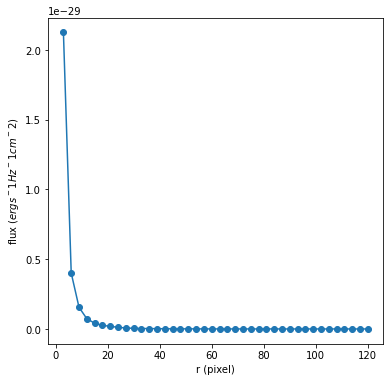

In [63]:
# 画出星系的一维面亮度图
unit = 3.631*10**(-6)*10**-23
flux_u = surface_flux*np.array(unit)

r = np.linspace(3,120,40)
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(r,flux_u)
plt.plot(r,flux_u)
plt.xlabel("r (pixel)")
plt.ylabel("flux ($erg s^-1 Hz^-1 cm^-2$)")

### 这个可以画成对数形式

### 5. 计算星等

In [67]:
m_AB = -2.5*np.log10(np.sum(flux)*3.631*10**(-6)/3631)
print(float(m_AB))

18.555355558183063
